# Operator Based Clustering

In [50]:
from lxml import etree

def depth(node):
    d = 0
    while node is not None:
        d += 1
        node = node.getparent()
    return d

def helper(fname):
    xml=etree.parse(fname)
    root=xml.getroot()
    ast=[]
    ast.append({'index':0,'type':'SELECT','depth':0,'parent':-1})
    curr=0
    for child in root.iter("{http://schemas.microsoft.com/sqlserver/2004/07/showplan}RelOp"):
        # print(depth(child),child.attrib['PhysicalOp'])
        parent=-1
        if(depth(child)>ast[curr]['depth']):
            parent=curr
        else:
            i=curr
            while(ast[i]['depth']>=depth(child)):
                i-=1
            parent=i
        curr+=1
        data={
            'index':curr,
            'type':child.attrib['PhysicalOp'],
            'depth':depth(child),
            'parent':parent
        }
        ast.append(data)
    return ast

def find_child(arr,index):
    temp=[]
    for i in range(len(arr)):
        if arr[i]['parent']==index:
            temp.append(i)
    return temp
        
        
def func(arr,index):
    lst=find_child(arr,index)
    temp={'type':arr[index]['type'],'children':[]}
    for i in lst:
        val = func(arr, i)
        if len(val['children'])==0:
            temp['children'].append({'type':val['type']})
        else:
            temp['children'].append(val)
    return temp

In [11]:
q_list=[0, 2, 3, 5, 8, 13, 18, 19, 21, 22, 23, 26, 28, 29, 30, 32, 40, 41, 46, 47, 49]

import json
for i in range(len(q_list)):
    fname="G:\dbquery-optimizer\Execution Plans\query_1\query_one_"+str(q_list[i]+1)+".xml"
    lookup=helper(fname)
    tree=[func(lookup,0)]
    with open(r"G:\dbquery-optimizer\notebooks\ast\query_one_"+str(q_list[i]+1)+".json",'w') as file:
        json.dump(tree,file)


In [27]:
import subprocess

main=r"G:\dbquery-optimizer\tree2vec\main.py"

for i in range(len(q_list)):
    inp=r"G:\dbquery-optimizer\notebooks\ast\query_one_"+str(q_list[i]+1)+".json"
    out=r"G:\dbquery-optimizer\notebooks\vectors\query_one_"+str(q_list[i]+1)+".json"
    try:
        p=subprocess.Popen(['python',main,'-i',inp,'-o',out],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        stderr=p.communicate()[0]
        if(stderr):
            print(stderr)
    except:
        print("Error")


103 1223


In [39]:
features=[]
exclude=[ 'chars_length_avg','chars_length_max',]
for i in range(len(q_list)):
    with open(r"G:\dbquery-optimizer\notebooks\vectors\query_one_"+str(q_list[i]+1)+".json",'r') as file:
        doc=json.load(file)
        for key in doc.keys():
            if(key not in features and key not in exclude ):
                features.append(key)

# len(features)

feature_val=[]
for i in range(len(q_list)):
    with open(r"G:\dbquery-optimizer\notebooks\vectors\query_one_"+str(q_list[i]+1)+".json",'r') as file:
        doc=json.load(file)
        row=[]
        for key in features:
            if(key in doc.keys()):
                row.append(doc[key])
            else:row.append(0)
        feature_val.append(row)
    
len(feature_val[0])

101

In [40]:
for i in range(len(q_list)):
    fname="G:\dbquery-optimizer\Execution Plans\query_1\query_one_"+str(q_list[i]+1)+".xml"
    xml=etree.parse(fname)
    root=xml.getroot()
    nodes=0
    merge_join=0
    nested_loops=0
    hash_match=0
    sort=0
    ci_scan=0
    filter=0
    aggr=0
    for child in root.iter("{http://schemas.microsoft.com/sqlserver/2004/07/showplan}RelOp"):
        op=child.attrib['PhysicalOp']
        if(op=='Stream Aggregate'):aggr+=1
        elif (op=='Hash Match'):hash_match+=1
        elif (op=='Filter'):filter+=1
        elif (op=='Clustered Index Scan'):ci_scan+=1
        elif(op=='Merge Join'):merge_join+=1
        elif(op=='Nested Loops'):nested_loops+=1
        elif(op=='Sort'):sort+=1
        nodes+=1
    row=[1,aggr,hash_match,merge_join,nested_loops,sort,filter,ci_scan]
    row=[i/nodes for i in row]
    row.append(nodes)
    for j in row:
        feature_val[i].append(j)



110

In [41]:
import numpy as np
feature_val=np.array(feature_val)
feature_val.shape

(21, 110)

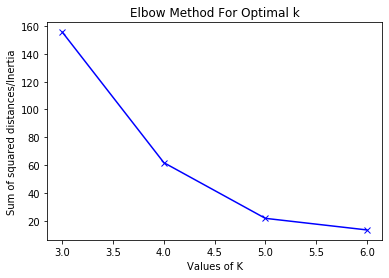

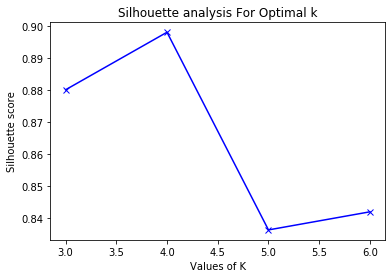

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
clusters= [i for i in range(3,7)]
Sum_of_squared_distances = []
for num_clusters in clusters :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(feature_val)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(clusters,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()
silhouette_avg = []
for num_clusters in clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(feature_val)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(feature_val, cluster_labels))
plt.plot(clusters,silhouette_avg,'bx-')
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [49]:
kmeans = KMeans(n_clusters=4,random_state=0).fit(feature_val)
kmeans.cluster_centers_
clusters=[{0:[],1:[],2:[],3:[]}]
for i in range(len(kmeans.labels_)):
    clusters[0][kmeans.labels_[i]].append(q_list[i]+1)

clusters

[{0: [1, 6, 22, 23, 29, 31, 42, 48],
  1: [3, 4, 14, 24, 27, 30, 33, 50],
  2: [20, 41, 47],
  3: [9, 19]}]

# Join-order Based Clustering

In [57]:
from lxml import etree

def depth(node):
    d = 0
    while node is not None:
        d += 1
        node = node.getparent()
    return d

def util(fname):
    xml=etree.parse(fname)
    root=xml.getroot()
    jot=[]
    jot.append({'index':0,'type':'root','depth':0,'parent':-1})
    curr=0
    joins=['Nested Loops','Merge Join','Hash Match']
    for child in root.iter("{http://schemas.microsoft.com/sqlserver/2004/07/showplan}RelOp"):  
        op=child.attrib['PhysicalOp']
        if(op in joins):
            # print(depth(child),child.attrib['PhysicalOp'])
            parent=-1
            if(depth(child)>jot[curr]['depth']):
                parent=curr
            else:
                i=curr
                while(jot[i]['depth']>=depth(child)):
                    i-=1
                parent=i
            curr+=1
            data={
                'index':curr,
                'type':child.attrib['PhysicalOp'],
                'depth':depth(child),
                'parent':parent
            }
            jot.append(data)
    return jot

def find_child(arr,index):
    temp=[]
    for i in range(len(arr)):
        if arr[i]['parent']==index:
            temp.append(i)
    return temp
        
        
def func(arr,index):
    lst=find_child(arr,index)
    temp={'type':arr[index]['type'],'children':[]}
    for i in lst:
        val = func(arr, i)
        if len(val['children'])==0:
            temp['children'].append({'type':val['type']})
        else:
            temp['children'].append(val)
    return temp

In [70]:
q_list=[0, 2, 3, 5, 8, 13, 18, 19, 21, 22, 23, 26, 28, 29, 30, 32, 40, 41, 46, 47, 49]

import json
for i in range(len(q_list)):
    fname="G:\dbquery-optimizer\Execution Plans\query_1\query_one_"+str(q_list[i]+1)+".xml"
    lookup=util(fname)
    tree=[func(lookup,1)]
    with open(r"G:\dbquery-optimizer\notebooks\jot\query_one_"+str(q_list[i]+1)+".json",'w') as file:
        json.dump(tree,file)

In [71]:
import subprocess

main=r"G:\dbquery-optimizer\tree2vec\main.py"

for i in range(len(q_list)):
    inp=r"G:\dbquery-optimizer\notebooks\jot\query_one_"+str(q_list[i]+1)+".json"
    out=r"G:\dbquery-optimizer\notebooks\jot-vectors\query_one_"+str(q_list[i]+1)+".json"
    try:
        p=subprocess.Popen(['python',main,'-i',inp,'-o',out],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        stderr=p.communicate()[0]
        if(stderr):
            print(stderr)
    except:
        print("Error")


In [87]:
jot_features=[]
# count=0
exclude=[ 'chars_length_avg','chars_length_max',]
for i in range(len(q_list)):
    with open(r"G:\dbquery-optimizer\notebooks\jot-vectors\query_one_"+str(q_list[i]+1)+".json",'r') as file:
        doc=json.load(file)
        for key in doc.keys():
            # count+=1
            if(key not in jot_features and key not in exclude ):
                jot_features.append(key)

# print(len(jot_features))

jot_vals=[]
for i in range(len(q_list)):
    with open(r"G:\dbquery-optimizer\notebooks\jot-vectors\query_one_"+str(q_list[i]+1)+".json",'r') as file:
        doc=json.load(file)
        row=[]
        for key in jot_features:
            if(key in doc.keys()):
                row.append(doc[key])
            else:row.append(0)
        jot_vals.append(row)


In [88]:
import numpy as np
jot_vals=np.array(jot_vals)
jot_vals

array([[ 6., 12., 18.,  6.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  6.,  4.,  6.,  6.,  1.,  1.,  1.,  3.,  2.,  3.,  6.,  5.],
       [ 4.,  6.,  4.,  6.,  6.,  1.,  1.,  1.,  3.,  2.,  3.,  6.,  5.],
       [ 6., 12., 18.,  6.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 6., 12., 13.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  6.,  4.,  6.,  6.,  1.,  1.,  1.,  3.,  2.,  3.,  6.,  5.],
       [ 6., 12., 13.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  9., 10.,  6.,  6.,  1.,  0.,  0.,  0.,  3.,  0.,  0.,  8.],
       [ 6., 12., 18.,  6.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 6., 12., 18.,  6.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  6.,  4.,  6.,  6.,  1.,  1.,  1.,  3.,  2.,  3.,  6.,  5.],
       [ 4.,  6.,  4.,  6.,  6.,  1.,  1.,  1.,  3.,  2.,  3.,  6.,  5.],
       [ 6., 12., 18.,  6.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  6.,  4.,  6.,  6.,  1., 

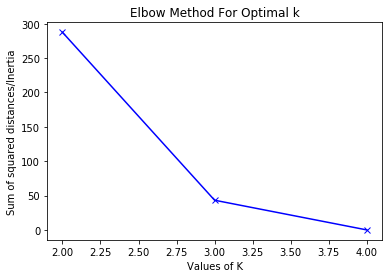

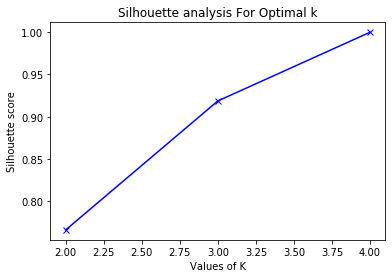

In [92]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
clusters= [i for i in range(2,5)]
Sum_of_squared_distances = []
for num_clusters in clusters :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(jot_vals)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(clusters,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()
silhouette_avg = []
for num_clusters in clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(jot_vals)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(jot_vals, cluster_labels))
plt.plot(clusters,silhouette_avg,'bx-')
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [94]:
kmeans = KMeans(n_clusters=4,random_state=0).fit(jot_vals)
kmeans.cluster_centers_
clusters=[{0:[],1:[],2:[],3:[]}]
for i in range(len(kmeans.labels_)):
    clusters[0][kmeans.labels_[i]].append(q_list[i]+1)

clusters

[{0: [1, 6, 22, 23, 29, 31, 42, 48],
  1: [3, 4, 14, 24, 27, 30, 33, 50],
  2: [20, 41, 47],
  3: [9, 19]}]